# DCRNN

In [ ]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.nn import GCNConv

In [ ]:
loader = METRLADatasetLoader()
dataset = loader.get_dataset(12,12)

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_temporal_data(train_dataset, num_sensors=5, sample =99):
    """
    Visualize the temporal data for a few sensors.
    
    Parameters:
    - train_dataset: List of Data objects containing x and y for each sample.
    - num_sensors: Number of sensors to visualize.
    - sample: timestamp to visualize
    """

    sample = train_dataset[sample]
    x = sample.x.numpy()
    y = sample.y.numpy()
    
    # Plot temporal data for the selected number of sensors
    for sensor_id in range(min(num_sensors, x.shape[0])):
        plt.figure(figsize=(10, 4))
        plt.plot(range(1, 13), x[sensor_id][0], marker='o', label='Input (Last 12 Timestamps)')
        plt.plot(range(13, 25), y[sensor_id, :], marker='x', label='Target (Next 12 Timestamps)')
        plt.title(f"Sensor {sensor_id + 1}: Temporal Data Visualization")
        plt.xlabel("Timestep")
        plt.ylabel("Sensor Value")
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
visualize_temporal_data(train_dataset, num_sensors=3)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric_temporal.nn.recurrent import DCRNN

class DCRNNModel(nn.Module):
    def __init__(self, in_channels, out_channels, K, num_nodes, horizon):
        super(DCRNNModel, self).__init__()
        self.dcrnn = DCRNN(in_channels, 32, K)
        # self.dcrnn2 = DCRNN(32, 64, K)
        # self.dcrnn3 = DCRNN(64, 32, K)
        # self.dcrnn4 = DCRNN(32, horizon, K)
        # self.spatial = GCNConv(in_channels=in_channels, out_channels=out_channels)
        self.fc = nn.Linear(32, horizon)
    
    def forward(self, x, edge_index, edge_weight):
        # x: Node features (in_channels, num_nodes)
        # edge_index: Graph connectivity (2, num_edges)
        h = self.dcrnn(x, edge_index, edge_weight).relu()
        # h = self.dcrnn2(h, edge_index, edge_weight).relu()
        # h = self.dcrnn3(h, edge_index, edge_weight).relu()
        # out = self.dcrnn4(h, edge_index, edge_weight).relu()
        # h = self.spatial(x, edge_index, edge_weight)
        out = self.fc(h)
        return out


In [36]:
def train(model, train_dataset, optimizer, criterion, num_epochs=20):
    model.train()
    loss_values = []
    for epoch in range(num_epochs):
        total_loss = 0
        for time, snapshot in enumerate(train_dataset):
            x, edge_index, y, edge_weight = snapshot.x[:,0], snapshot.edge_index, snapshot.y, snapshot.edge_weight
            optimizer.zero_grad()
            out = model(x, edge_index, edge_weight)
            # print(len(out))
            # print('---------------------------------------------------------------------------------------------')
            # print(len(y))
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_values.append(total_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")
    return loss_values
    

In [37]:
# Hyperparameters
in_channels = 12
out_channels = 12
K = 1
num_nodes = 207
horizon = 12

model = DCRNNModel(in_channels, out_channels, K, num_nodes, horizon)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train the model
loss_values = train(model, train_dataset, optimizer, criterion, num_epochs=20)

Epoch 1/20, Loss: 8770.6663
Epoch 2/20, Loss: 9299.9841
Epoch 3/20, Loss: 8708.3383
Epoch 4/20, Loss: 8662.9198
Epoch 5/20, Loss: 8582.7076
Epoch 6/20, Loss: 8624.5860
Epoch 7/20, Loss: 8550.8066
Epoch 8/20, Loss: 8695.9534
Epoch 9/20, Loss: 9068.6207
Epoch 10/20, Loss: 8906.6924
Epoch 11/20, Loss: 8557.0432
Epoch 12/20, Loss: 8803.4507
Epoch 13/20, Loss: 8578.6421
Epoch 14/20, Loss: 9549.2213
Epoch 15/20, Loss: 8696.7978
Epoch 16/20, Loss: 9198.3878
Epoch 17/20, Loss: 8749.6521
Epoch 18/20, Loss: 8747.3587
Epoch 19/20, Loss: 8491.6607
Epoch 20/20, Loss: 8679.7486


In [38]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def visualize_forecast(test_dataset, model, train_dataset, num_sensors=5, sample=99):
    """
    Visualize the temporal training data (x), actual data (y), and the forecasted value.
    
    Parameters:
    - test_dataset: The dataset used for testing, should contain x and y.
    - model: The trained forecasting model.
    - train_dataset: The dataset used for training, to show historical data.
    - num_sensors: Number of sensors to visualize.
    - sample: Index of the sample to visualize from the test dataset.
    """
    for idx, snapshot in enumerate(test_dataset):
        ground_truth = []
        predictions = []
        
        # Extract data for the given sample
        x_sample = test_dataset[idx].x[:, 0]
        y_actual = test_dataset[idx].y
        edge_index = test_dataset[idx].edge_index
        edge_weight = test_dataset[idx].edge_weight
    
        # Model prediction
        with torch.no_grad():
            model.eval()
            y_pred = model(x_sample, edge_index, edge_weight)
            predictions.append(y_pred)
            ground_truth.append(y_actual)
    
        # Calculate MAE (Mean Absolute Error)
        mae = F.l1_loss(y_pred, y_actual)
        
        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = torch.mean(torch.abs((y_actual - y_pred) / y_actual)) * 100
        
        # Calculate RMSE (Root Mean Squared Error)
        rmse = torch.sqrt(F.mse_loss(y_pred, y_actual))
    
    # Print or display the scores
    print(f"Sample {sample} - MAE: {mae.item():.4f}, MAPE: {mape.item():.2f}%, RMSE: {rmse.item():.4f}")

    # Plotting
    fig, axs = plt.subplots(num_sensors, 1, figsize=(10, 5 * num_sensors), sharex=True)
    
    if num_sensors == 1:
        axs = [axs]  # Make axs iterable if there's only one sensor

    for i in range(num_sensors):
        # Plot all data on the same subplot
        # axs[i].plot(train_dataset[sample].x[i, 0], label='Training Data', linestyle='--', color='gray')
        axs[i].plot(y_actual[i].numpy(), label='Actual Data', color='blue')
        axs[i].plot(y_pred[i].numpy(), label='Forecasted Data', color='red')
        
        axs[i].set_title(f'Sensor {i}')
        axs[i].legend()

    # Display the metrics on the plot
    plt.suptitle(f'Sample {sample} - MAE: {mae.item():.4f}, MAPE: {mape.item():.2f}%, RMSE: {rmse.item():.4f}', fontsize=16)
    
    plt.xlabel('Time Steps')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()
    return ground_truth, predictions
# Example usage:
# visualize_forecast(test_dataset, model_STGCN, train_dataset, num_sensors=15)


Sample 0 - MAE: 0.2262, MAPE: 122.95%, RMSE: 0.3461


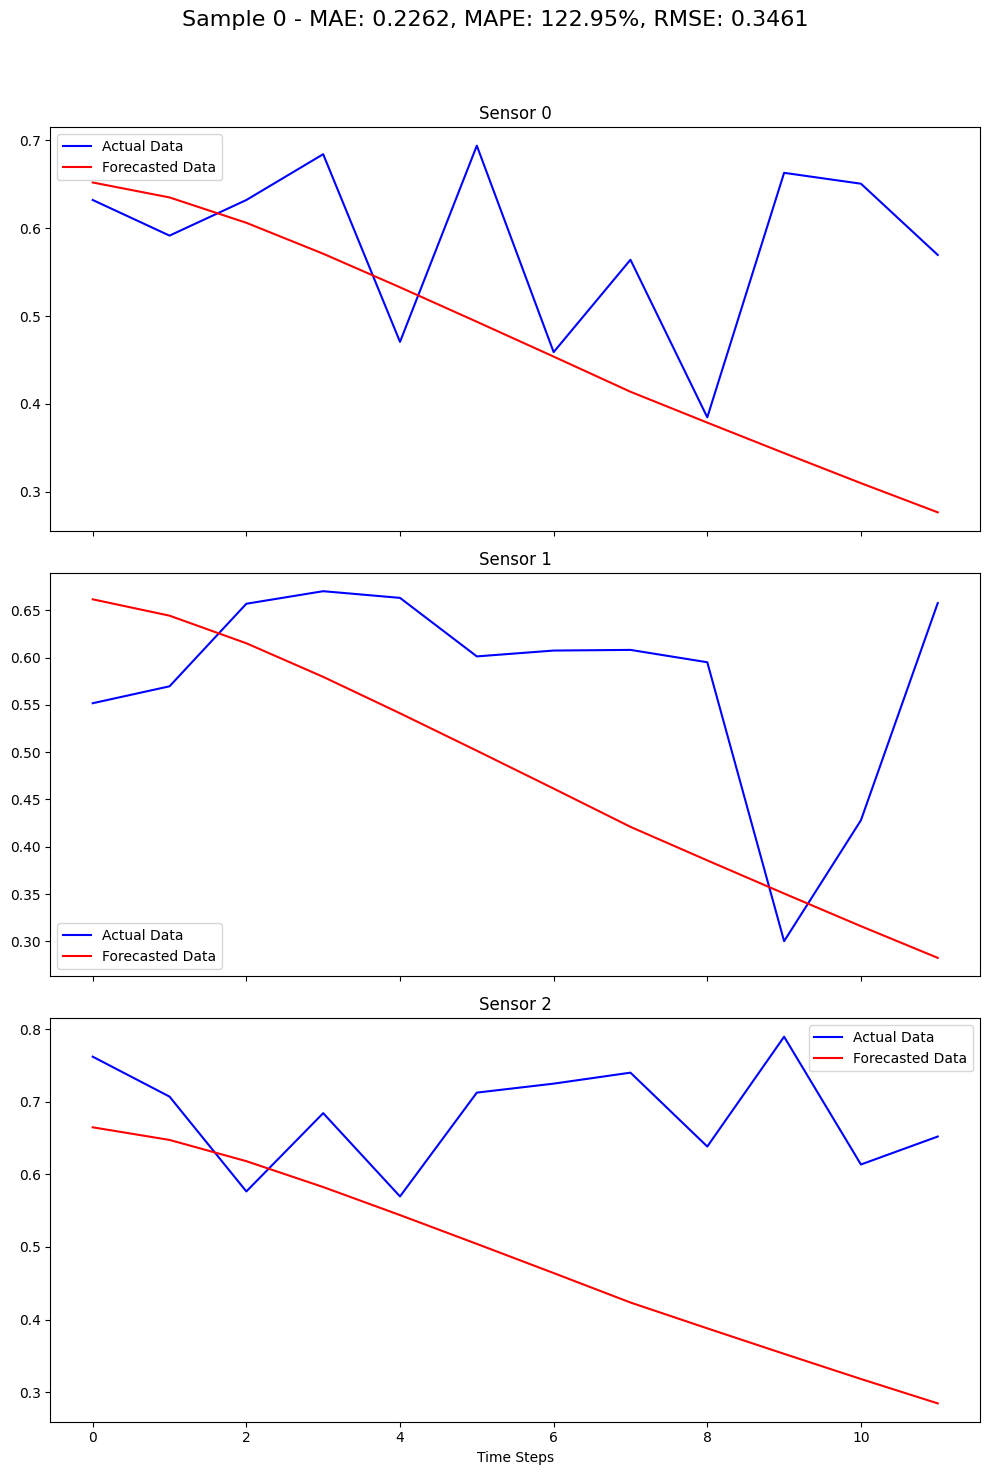

In [42]:
ground_truth, predictions=visualize_forecast(test_dataset, model, train_dataset, num_sensors = 3, sample = 0)